# Lambda School Data Science - A First Look at Data



In [0]:
# 2019-05-28 Changed by Nov05

## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

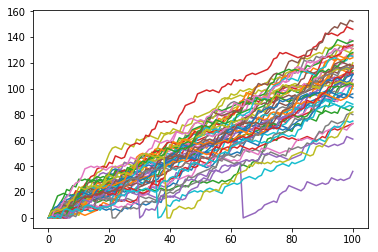

In [9]:
# TODO - your code here
# Use what we did live in lecture as an example

import matplotlib.pyplot as plt
import numpy as np

all_walks =[]

for _ in range(50):
  random_walk = [0]
  
  for _ in range (100):
    step = random_walk[-1]
    dice = np.random.randint(1, 7) # throw a dice
    if dice <= 2:
      step = max(0, step-1)
    elif dice > 3 and dice <= 5:
      step += 1
    else:
      step += np.random.randint(1, 7) # throw a dice again
    # clumsiness
    if np.random.rand() <= 0.001:
      step = 0  
    random_walk.append(step) 
    
  all_walks.append(random_walk)
  
np_aw_t = np.transpose(np.array(all_walks))   
plt.plot(np_aw_t)
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




**Answers:**
1. I took Udacity PyTorch Challenge in November and December in 2018. I did a little deep learning programming, and finished several interesting projects, such as using LSTM character CNN to learn from the Russian novel Anna Karenina, then generate a whole chapter of texts.

2. The challenge part is actually to get the shaple of input output tensors right.

3. Well, the possibility to apply deep learning in many fields.

4. I want to have better understanding of models, rather than only know how to adjust parameters of the models.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.